# Problem Statement

Let's take a case where an advertiser on the platform (DeltaX) would like to estimate the performance of their campaign in the future.

Imagine it is the first day of March and you are given the past performance data of ads between 1st August to 28th Feb. You are now tasked to predict an ad's future performance (revenue) between March 1st and March 15th. Well, it is now time for you to put on your problem-solving hats and start playing with the data provided under the "data" section.

In [1]:
# importing libraries for EDA
import pandas as pd
import numpy as np

In [2]:
# reading the training dataset
data = pd.read_csv('Train_Data.csv')

In [3]:
# basic EDA
data.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [4]:
# basic EDA
data.shape

(4571, 9)

In [5]:
# basic EDA
data.columns

Index(['date', 'campaign', 'adgroup', 'ad', 'impressions', 'clicks', 'cost',
       'conversions', 'revenue'],
      dtype='object')

In [6]:
# basic EDA
data.dtypes

date            object
campaign        object
adgroup         object
ad              object
impressions      int64
clicks           int64
cost           float64
conversions      int64
revenue        float64
dtype: object

In [7]:
# checking for missing values
data.isnull().sum()

date           0
campaign       0
adgroup        0
ad             0
impressions    0
clicks         0
cost           0
conversions    0
revenue        0
dtype: int64

In [8]:
# engineering features to improve the accuracy
data['CTR'] = data['clicks']/data.loc[data['impressions']>0, 'impressions']
data['CPC'] = data['clicks']/data.loc[data['cost']>0, 'cost']
data['CPA'] = data['cost']/data.loc[data['conversions']>0, 'conversions']
data['CIE'] = data['conversions']/data.loc[data['impressions']>0, 'impressions']
data['CCE'] = data['conversions']/data.loc[data['clicks']>0, 'clicks']
data['CCI'] = data['impressions']/data.loc[data['cost']>0, 'cost']

# data.loc is used to prevent infinite value calculation
# missing values generated will be imputed in the preprocessor pipeline

In [9]:
# engineering feature to replace the target variable
data['ROI'] = data.loc[data['revenue']>0,'revenue']/data.loc[data.cost>0, 'cost']

In [10]:
# filling missing values in the new target variable
data.ROI.fillna(value=0,inplace=True)

In [11]:
# splitting the dependent and independent variables in the dataset
y = data.ROI
X = data.drop(columns=['date','revenue','ROI'])

In [12]:
# splitting the training dataset for evaluating the model
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, random_state=9)

In [13]:
# selecting the categorical columns with relatively low cardinality
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and  X_train_full[cname].dtype == "object"]

In [14]:
# selecting the numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

In [15]:
# keeping the selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [16]:
# importing libraries for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

# scaling the numerical columns and imputing the missing values
numerical_transformer = Pipeline(steps = [
    ('scaler', RobustScaler()),   
    ('imputer', SimpleImputer(strategy='mean')),
])

# one-hot encoding the categorical columns and imputing the missing values
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='median')),
])

# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
      ])

In [17]:
# building model for prediction
from xgboost import XGBRFRegressor
xgbrfr = XGBRFRegressor(max_depth=8, random_state=22)

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                              ('xgbrfr', xgbrfr)
                             ])

# preprocessing of training data from training dataset and fitting the model 
my_pipeline.fit(X_train, y_train)

# evaluating the model using testing data from training dataset
score = sqrt(mean_squared_error(y_valid, my_pipeline.predict(X_valid)))
print('Score:',score)

[14:14:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score: 347.3386143859124


In [19]:
# reading the testing dataset
df = pd.read_csv('Test_Data.csv')

In [20]:
df.head()

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.58,121,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.17,22,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.05,5,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.01,2,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.01,3,1,0


In [21]:
# engineering features to improve the accuracy
df['CTR'] = df['clicks']/df.loc[df['impressions']>0, 'impressions']
df['CPC'] = df['cost']/df.loc[df['clicks']>0, 'clicks']
df['CPA'] = df['cost']/df.loc[df['conversions']>0, 'conversions']
df['CIE'] = df['conversions']/df.loc[df['impressions']>0, 'impressions']
df['CCE'] = df['conversions']/df.loc[df['clicks']>0, 'clicks']
df['CCI'] = df['cost']/df.loc[df['impressions']>0, 'impressions']

In [22]:
# predicting the target variable
ROI = my_pipeline.predict(df)

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [23]:
# calculating actual target variable from prediction
dfr=pd.DataFrame([ROI])
dfr=dfr.T
dfr.columns=(['ROI'])
dfr['revenue'] = dfr.loc[dfr.ROI>0, 'ROI']*df.loc[df.cost>0,'cost']
dfr.revenue.fillna(value=0, inplace=True)

# formatting the predictions to specified format of submission
dfr.index=dfr['revenue']
dfr=dfr.drop(columns=['revenue','ROI'])

In [24]:
# saving the predictions as a csv file.
dfr.to_csv('submission.csv')

#### Final Rank on Private Leaderboard with RMSE.

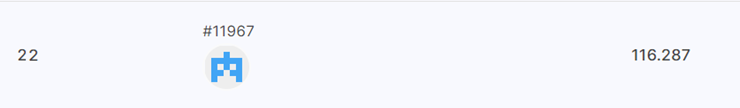